# Setup 🏗️


In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from random import randrange




In [2]:
viscos = 1/5200

# load RANS data created by rans.m (which can be downloaded)
# load DNS data
DNS_mean  = np.genfromtxt("LM_Channel_5200_mean_prof.dat",comments="%").transpose()
y_DNS     = DNS_mean[0]
yplus_DNS = DNS_mean[1]
u_DNS     = DNS_mean[2]
dudy_DNS  = np.gradient(u_DNS,y_DNS)

DNS_stress = np.genfromtxt("LM_Channel_5200_vel_fluc_prof.dat",comments="%").transpose()

uu_DNS = DNS_stress[2]
vv_DNS = DNS_stress[3]
ww_DNS = DNS_stress[4]
uv_DNS = DNS_stress[5]
uw_DNS = DNS_stress[6]
vw_DNS = DNS_stress[7]
k_DNS  = 0.5*(uu_DNS+vv_DNS+ww_DNS)

DNS_RSTE = np.genfromtxt("LM_Channel_5200_RSTE_k_prof.dat",comments="%")

eps_DNS = DNS_RSTE[:,7]/viscos # it is scaled with ustar**4/viscos

# fix wall
eps_DNS[0]=eps_DNS[1]

# load data from k-omega RANS
data  = np.loadtxt('y_u_k_om_uv_5200-RANS-code.txt').transpose()
y     = data[0]
u     = data[1]
k     = data[2]
om    = data[3]
diss1 = 0.09*k*om
ustar = (viscos*u[0]/y[0])**0.5
yplus = y*ustar/viscos

# dont train on, uu, vv, ww, uv, uw, vw 
# Maybe mixed terms are ok (just not uu,vv,ww)

#-----------------Data_manipulation--------------------

# Delete first value for all interesting data
uv_DNS    = np.delete(uv_DNS, 0)
vv_DNS    = np.delete(vv_DNS, 0)
ww_DNS    = np.delete(ww_DNS, 0)
uw_DNS    = np.delete(uw_DNS,0)
vw_DNS    = np.delete(vw_DNS,0)
k_DNS     = np.delete(k_DNS, 0)
eps_DNS   = np.delete(eps_DNS, 0)
dudy_DNS  = np.delete(dudy_DNS, 0)
yplus_DNS = np.delete(yplus_DNS,0)
uu_DNS    = np.delete(uu_DNS,0)
y_DNS     = np.delete(y_DNS,0)
u_DNS     = np.delete(u_DNS,0)

# Calculate ny_t and time-scale tau
viscous_t = k_DNS**2/eps_DNS 
tau       = viscous_t/abs(uv_DNS)

# Calculate c_1, c_2, & c_3 of the Non-linear Eddy Viscosity Model
# Array for storing c_1, c_2, & c_3
c_0 = -2*(ww_DNS/k_DNS - 2/3)/(tau**2*dudy_DNS**2)
c_2 = 2*((ww_DNS/k_DNS - 2/3) + (uu_DNS/k_DNS - 2/3))/(tau**2*dudy_DNS**2)

c = np.array([c_0,c_2])

dudy_squared_DNS = (dudy_DNS**2).reshape(-1,1)

#TODO ML using PyTorch to estimate c_1, c_2, & c_3


Setting up input and output as tensors 

In [3]:

def reshape_those_fuckers(*args):
    return [arg.reshape(-1,1) for arg in args]



X = StandardScaler().fit_transform(dudy_squared_DNS)

# transpose the target vector to make it a column vector  
y = c.transpose()

#tau, dudy, k, uu, vv, ww, yplus_DNS
test_var = np.concatenate((reshape_those_fuckers(tau,dudy_DNS,k_DNS,uu_DNS,vv_DNS,ww_DNS,yplus_DNS, c[0,:],c[1,:])),axis=1)

# split the feature matrix and target vector into training and validation sets
# test_size=0.2 means we reserve 20% of the data for validation
# random_state=42 is a fixed seed for the random number generator, ensuring reproducibility

random_state = randrange(100)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state= random_state)
X_train, X_val, test_var_train, test_var_val = train_test_split(X, test_var, test_size=0.2, random_state= random_state)

# convert the numpy arrays to PyTorch tensors with float32 data type
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# create PyTorch datasets and dataloaders for the training and validation sets
# a TensorDataset wraps the feature and target tensors into a single dataset
# a DataLoader loads the data in batches and shuffles the batches if shuffle=True
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
print(test_var_val)

[[1.24921099e+00 1.45326764e+01 3.43920388e+00 ... 9.39970636e+02
  1.08433077e-03 2.00605997e-03]
 [8.69162346e-01 2.39065996e+01 3.92761698e+00 ... 5.65785534e+02
  8.31343338e-04 1.64884714e-03]
 [1.45462906e+00 1.17835556e+01 3.17761719e+00 ... 1.17818266e+03
  1.18668931e-03 2.15944611e-03]
 ...
 [7.22177197e-02 2.11390540e+03 5.55573462e+00 ... 1.30175344e+01
  2.83351346e-05 5.32280072e-05]
 [1.00246085e+01 1.09142140e+00 9.01393631e-01 ... 4.80856247e+03
  1.93183571e-03 2.15345361e-03]
 [3.51444016e+00 3.80272554e+00 1.30247682e+00 ... 3.71132942e+03
  1.59265815e-03 2.40865945e-03]]


Let's set up a neural network:

In [5]:
class ThePredictionMachine(nn.Module):

    def __init__(self):
        
        super(ThePredictionMachine, self).__init__()

        self.input   = nn.Linear(1, 50)     
        self.hidden1 = nn.Linear(50, 25)    
        self.hidden2 = nn.Linear(25, 2)     

    def forward(self, x):
        x = nn.functional.relu(self.input(x))
        x = nn.functional.relu(self.hidden1(x))
        x = self.hidden2(x)
        return x


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    print(f"Avg loss: {test_loss:>8f} \n")

In [7]:
# Instantiate a neural network
neural_net = ThePredictionMachine()

# Set up hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 1000

# Initialize the loss function
loss_fn = nn.MSELoss()

# Choose loss function, check out https://pytorch.org/docs/stable/optim.html for more info
# In this case we choose Stocastic Gradient Descent
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, neural_net, loss_fn, optimizer)
    test_loop(val_loader, neural_net, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Avg loss: 0.003739 

Epoch 2
-------------------------------
Avg loss: 0.003493 

Epoch 3
-------------------------------
Avg loss: 0.003266 

Epoch 4
-------------------------------
Avg loss: 0.003054 

Epoch 5
-------------------------------
Avg loss: 0.002859 

Epoch 6
-------------------------------
Avg loss: 0.002677 

Epoch 7
-------------------------------
Avg loss: 0.002508 

Epoch 8
-------------------------------
Avg loss: 0.002351 

Epoch 9
-------------------------------
Avg loss: 0.002206 

Epoch 10
-------------------------------
Avg loss: 0.002070 

Epoch 11
-------------------------------
Avg loss: 0.001943 

Epoch 12
-------------------------------
Avg loss: 0.001825 

Epoch 13
-------------------------------
Avg loss: 0.001715 

Epoch 14
-------------------------------
Avg loss: 0.001612 

Epoch 15
-------------------------------
Avg loss: 0.001516 

Epoch 16
-------------------------------
Avg loss: 0.001426 

Epoch 17
--------

In [8]:
preds = neural_net(X_val_tensor)

In [9]:
print(preds)


tensor([[ 8.3277e-04,  1.7651e-03],
        [ 8.4293e-04,  1.7630e-03],
        [ 8.3071e-04,  1.7655e-03],
        [ 8.2927e-04,  1.7658e-03],
        [ 8.6223e-04,  1.7591e-03],
        [ 9.0169e-04,  1.7512e-03],
        [ 8.2685e-04,  1.7663e-03],
        [ 8.4029e-04,  1.7636e-03],
        [ 8.6685e-04,  1.7582e-03],
        [ 9.4479e-04,  1.7425e-03],
        [ 8.3478e-04,  1.7647e-03],
        [ 8.5178e-04,  1.7613e-03],
        [ 9.7349e-04,  1.7367e-03],
        [ 8.2971e-04,  1.7657e-03],
        [ 8.2763e-04,  1.7661e-03],
        [ 8.2784e-04,  1.7661e-03],
        [ 8.3929e-04,  1.7638e-03],
        [ 8.2849e-04,  1.7660e-03],
        [ 8.3010e-04,  1.7656e-03],
        [ 8.2799e-04,  1.7661e-03],
        [ 8.2863e-04,  1.7659e-03],
        [ 8.2729e-04,  1.7662e-03],
        [ 8.2701e-04,  1.7662e-03],
        [ 8.5882e-04,  1.7598e-03],
        [ 8.2742e-04,  1.7661e-03],
        [ 8.2878e-04,  1.7659e-03],
        [ 9.2767e-04,  1.7460e-03],
        [ 2.3794e-03,  3.633

In [10]:
print(y_val_tensor)

tensor([[1.0843e-03, 2.0061e-03],
        [8.3134e-04, 1.6488e-03],
        [1.1867e-03, 2.1594e-03],
        [1.2807e-03, 2.3071e-03],
        [6.7397e-04, 1.4428e-03],
        [5.6851e-04, 1.3366e-03],
        [1.9498e-03, 2.0711e-03],
        [8.7382e-04, 1.7072e-03],
        [6.5332e-04, 1.4181e-03],
        [5.2342e-04, 1.3204e-03],
        [1.0081e-03, 1.8962e-03],
        [7.3834e-04, 1.5241e-03],
        [5.0565e-04, 1.3258e-03],
        [1.2532e-03, 2.2623e-03],
        [1.4044e-03, 2.4160e-03],
        [1.3974e-03, 2.4490e-03],
        [8.9307e-04, 1.7338e-03],
        [1.3469e-03, 2.4169e-03],
        [1.2269e-03, 2.2199e-03],
        [1.3809e-03, 2.4389e-03],
        [1.3348e-03, 2.3964e-03],
        [1.5557e-03, 2.4033e-03],
        [1.7895e-03, 2.3465e-03],
        [6.9159e-04, 1.4646e-03],
        [1.4544e-03, 2.3860e-03],
        [1.3183e-03, 2.3680e-03],
        [5.3766e-04, 1.3220e-03],
        [3.3346e-05, 6.3632e-05],
        [1.1473e-03, 2.1002e-03],
        [6.180

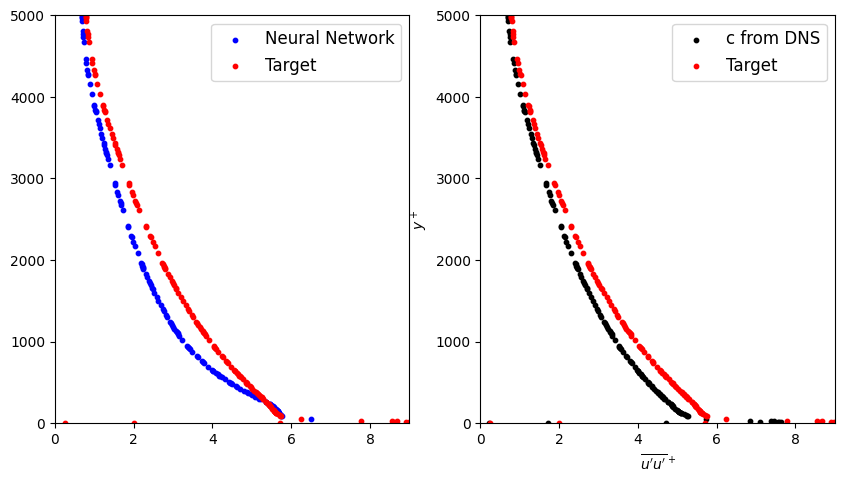

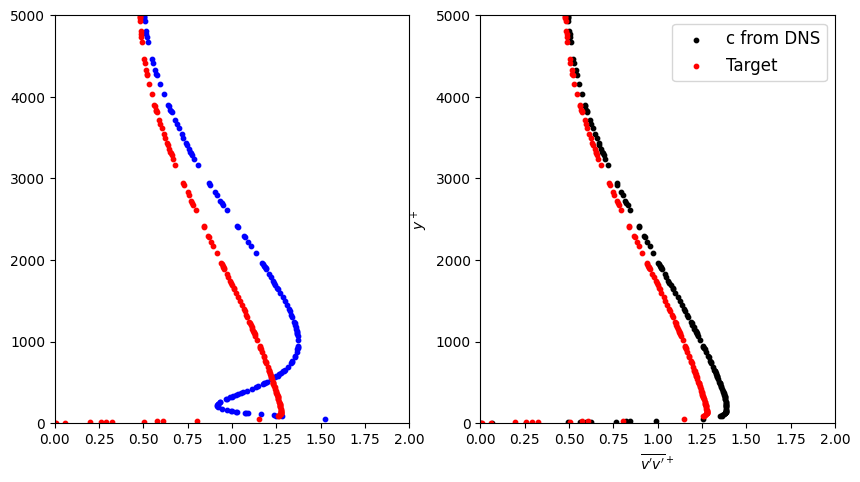

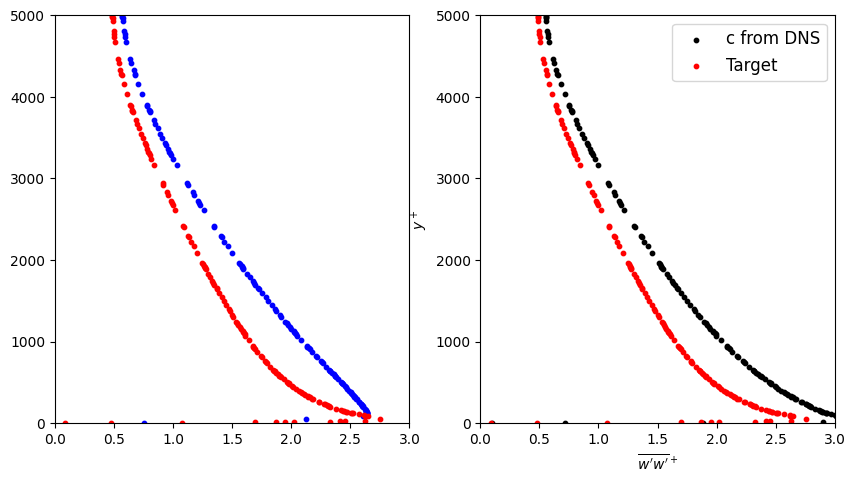

In [11]:
c_NN = preds.detach().numpy()

#tau, dudy, k, uu, vv, ww, yplus, c_0,c_2
ww_NN = ((c_NN[:,0])*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_NN[:,0]) + 6*(c_NN[:,1])) + 2/3)*test_var_val[:,2]
vv_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_NN[:,0]) - 6*(c_NN[:,1])) + 2/3)*test_var_val[:,2]


ww_DNSC = ((test_var_val[:,7])*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_DNSC = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((test_var_val[:,7]) + 6*(test_var_val[:,8])) + 2/3)*test_var_val[:,2]
vv_DNSC = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((test_var_val[:,7]) - 6*(test_var_val[:,8])) + 2/3)*test_var_val[:,2]


fig1, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax0.scatter(uu_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax0.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax0.axis([0,9,0,5000])
ax0.legend(loc = "best", fontsize = 12)

ax1.scatter(uu_DNSC,test_var_val[:,6], marker="o", s=10, c="k", label="c from DNS")
ax1.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
plt.axis([0, 9, 0,5000])
plt.xlabel("$\overline{u'u'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig2, (ax2,ax3) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax2.scatter(vv_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax2.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax2.axis([0, 2, 0,5000])

ax3.scatter(vv_DNSC,test_var_val[:,6], marker="o", s=10, c="k", label="c from DNS")
ax3.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax3.axis([0, 2, 0,5000])
plt.xlabel("$\overline{v'v'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig3, (ax4,ax5) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax4.scatter(ww_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax4.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax4.axis([0, 3, 0,5000])

ax5.scatter(ww_DNSC,test_var_val[:,6], marker="o", s=10, c="k", label="c from DNS")
ax5.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax5.axis([0, 3, 0,5000])
plt.xlabel("$\overline{w'w'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

plt.show()

0.04738414655446354
0.07419180683210531


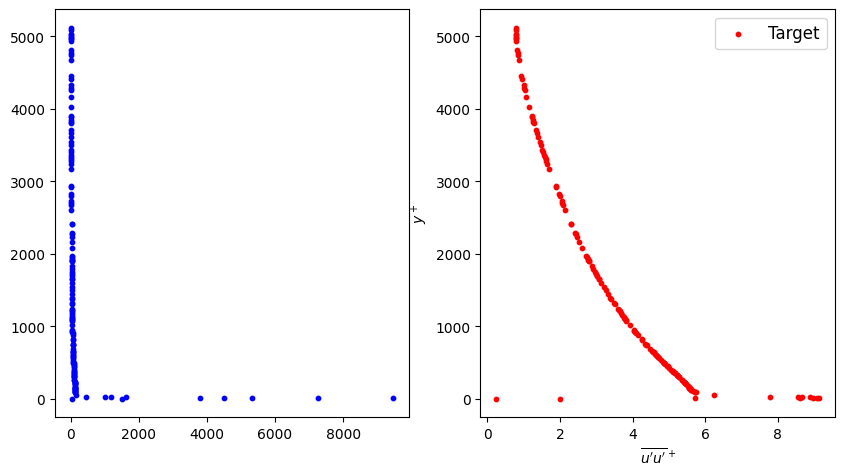

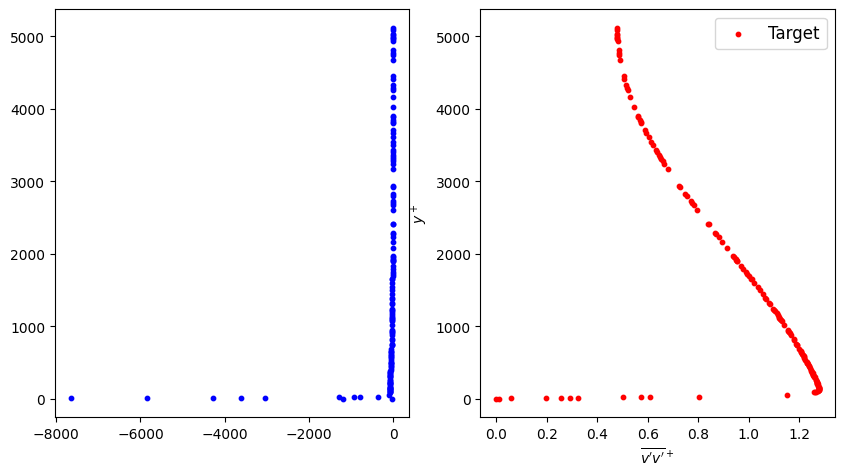

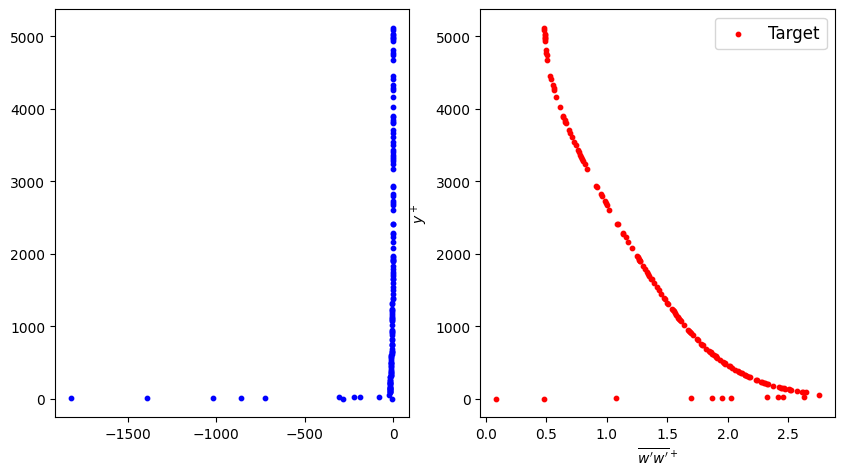

In [13]:
c_NN = y_val_tensor.detach().numpy()

#Not sure how to correctly find mean value, this gives bad results
c_0_NN = np.mean(np.trapz(c_NN[:,0],test_var_val[:,6])/test_var_val[:,6])
c_2_NN = np.mean(np.trapz(c_NN[:,1],test_var_val[:,6])/test_var_val[:,6])

print(c_0_NN)
print(c_2_NN)

#tau, dudy, k, uu, vv, ww, yplus
ww_NN = ((c_0_NN)*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_NN) + 6*(c_2_NN)) + 2/3)*test_var_val[:,2]
vv_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_NN) - 6*(c_2_NN)) + 2/3)*test_var_val[:,2]


fig1, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax0.scatter(uu_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax1.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
#ax0.axis([-70, 0, 0,5000])
plt.xlabel("$\overline{u'u'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig2, (ax2,ax3) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax2.scatter(vv_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax3.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
#ax2.axis([0, 100, 0,5000])
plt.xlabel("$\overline{v'v'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig3, (ax4,ax5) = plt.subplots(nrows = 1,ncols =2,figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax4.scatter(ww_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax5.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
#ax4.axis([0, 11, 0,5000])
plt.xlabel("$\overline{w'w'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

plt.show()